<a href="https://colab.research.google.com/github/yuvalgos/course_recommender_system/blob/master/recommender_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ratings Data Set
The data was collected from technion course recommender site. Each row represent a rating for a course by one student, and that rating is divided into workload an difficuly of the course. Both ratings for workload and difficuly are deom 1 to 10, while in the instruction students are encouraged to use all of the scale, we will check how they did later. 
 
The dataset ia expected to be sparce since there are studenta from different facultys, and there are more then 1,000 courses, most of them are not rated.

# Loading The Data

In [114]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 5]
ratings = pd.read_csv('https://raw.githubusercontent.com/yuvalgos/course_recommender_system/master/data_pool/ratings_data_2021feb24.csv')
ratings.sample(5)

,id,user,course,difficulty,workload,final_grade,semesters_taken,created_at,updated_at
100,108,16,234128,4.0,6.0,70.0,NaN,2020-10-22 14:52:23.604615+00:00,2020-10-22 14:52:23.604657+00:00
161,171,27,234124,7.5,10.0,86.0,NaN,2020-10-23 08:52:20.302981+00:00,2020-10-23 08:52:20.303032+00:00
523,542,56,104281,7.0,6.0,94.0,NaN,2021-01-04 12:02:44.787605+00:00,2021-01-04 12:06:18.963860+00:00
229,242,33,104035,7.5,7.0,93.0,NaN,2020-10-24 12:48:10.219795+00:00,2020-10-24 12:48:10.219821+00:00
130,139,22,14008,4.0,4.0,80.0,NaN,2020-10-22 20:26:32.903508+00:00,2020-10-22 20:27:01.698299+00:00


We will only use the four leftest fields because all the other fields are not mandatory or irrelevant. Some of the other fields may be in use in the future.

In [115]:
ratings_diff = ratings[["user", "course", "difficulty"]]
ratings_wl = ratings[["user", "course", "workload"]]
ratings_combined = ratings[["user", "course", "difficulty", "workload"]]
 
ratings_combined.sample(5)

,user,course,difficulty,workload
653,76,234124,7.5,9.5
547,58,44252,7.5,7.0
434,54,234114,4.0,3.5
88,7,104034,6.0,4.5
684,82,44131,5.0,6.5


# Inital Analysis And Visualization

## Inital Information

In [116]:
users_counts = ratings_diff["user"].value_counts()
courses_counts = ratings_diff["course"].value_counts()
print("number of ratings:", len(ratings_diff["user"]))
print("number of courses rated:", len(courses_counts))
print("number of students with ratings:", len(users_counts))
print()
 
print("mean difficulty:", ratings_diff["difficulty"].mean())
print("mean workload:", ratings_wl["workload"].mean())

number of ratings: 744
number of courses rated: 248
number of students with ratings: 59

mean difficulty: 6.084677419354839
mean workload: 5.606854838709677


## Courses

### Ratings Count

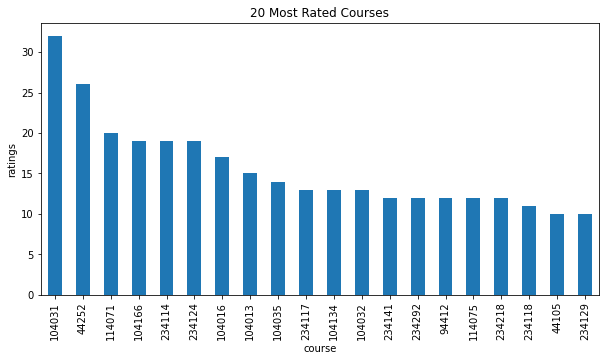

In [117]:
ax = courses_counts.iloc[0:20].plot.bar(title="20 Most Rated Courses",
                                        xlabel="course",
                                        ylabel="ratings",)

amount of courses with more then 2 ratings: 63
amount of courses with more then 5 ratings: 33
amount of courses with more then 10 ratings: 18


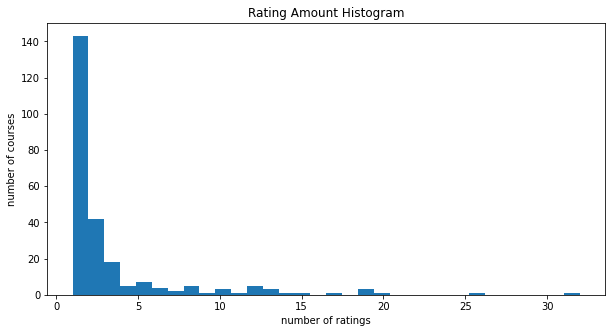

In [118]:
ax = courses_counts.plot.hist(bins=courses_counts.max(),
                              title="Rating Amount Histogram",)
ax.set_xlabel("number of ratings")
ax.set_ylabel("number of courses")
 
print("amount of courses with more then 2 ratings:",
      (courses_counts[courses_counts > 2]).count())
print("amount of courses with more then 5 ratings:",
      (courses_counts[courses_counts > 5]).count())
print("amount of courses with more then 10 ratings:",
      (courses_counts[courses_counts > 10]).count())

It seems that the majority of the qcourses has less then 5 ratings (most of them has 1) and there are few courses with high rating amount. Classic [power law](https://en.wikipedia.org/wiki/Power_law) distribution.
Because courses with one rating are not usefull, as they can't help us predict, we will remove them later.

## Average Ratings

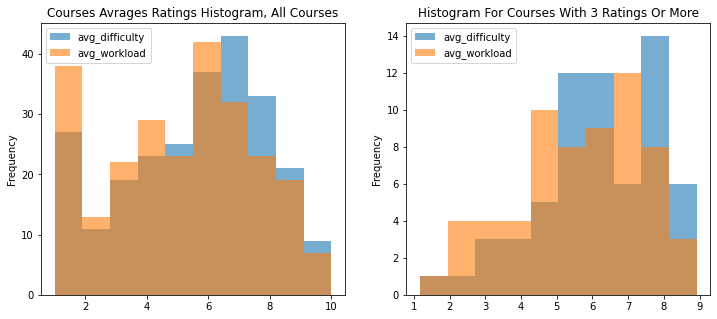

In [119]:
courses_df = courses_counts.to_frame(name="ratings_count")
courses_df["avg_difficulty"] = -1
courses_df["avg_workload"] = -1
 
for course in courses_counts.index:
    one_course_ratings = ratings_combined[ratings_combined["course"] == course]
    courses_df.loc[course, "avg_difficulty"] = one_course_ratings["difficulty"].mean()
    courses_df.loc[course, "avg_workload"] = one_course_ratings["workload"].mean()
 
fig, ax = plt.subplots(nrows=1, ncols=2)

_ = courses_df[["avg_difficulty", "avg_workload"]].plot.hist(ax=ax[0],
                                                        alpha=0.6,
                                                        figsize=[12,5],
                                                        title="Courses Avrages Ratings Histogram, All Courses")
# make the same plot but only for courses with moore then 2 ratings:
courses_highly_rated_df = courses_df[courses_df["ratings_count"] > 2]
_ =courses_highly_rated_df[["avg_difficulty", "avg_workload"]].plot.hist(ax=ax[1],
                                                                      alpha=0.6,
                                                                      title="Histogram For Courses With 3 Ratings Or More")

The courses average ratings seem to be diatributed well, especially when ignoring courses with one or two ratings.

## Students

### ratings count

students with 8 ratings or more: 37


Text(0, 0.5, 'number of users')

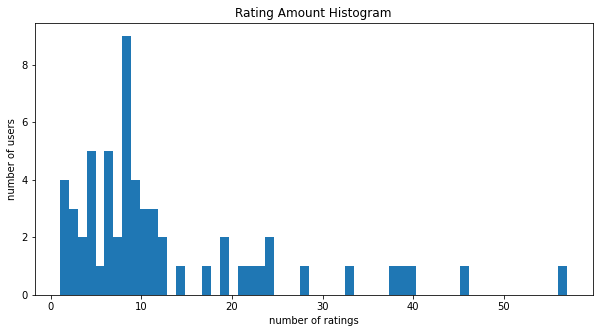

In [120]:
print("students with 8 ratings or more:", len(users_counts[users_counts >= 8]))
 
ax = users_counts.plot.hist(bins=users_counts.max(),
                              title="Rating Amount Histogram",)
ax.set_xlabel("number of ratings")
ax.set_ylabel("number of users")

A lot of students have 8 ratings because it was stated that in order to get an prediction for courses, one must have at least 8 ratings. Later we will check if  the minimum number of ratings can be lowered with out damaging the accuracy. 
 
I specificly checked the ratings of the student with 57 ratings, and they actualy make sense and not random, it's a biomedical engineering student.

In [121]:
# those calculation are for the 2 next graphs :
users_df = users_counts.to_frame(name="ratings_count")
users_df["avg_difficulty"] = -1
users_df["avg_workload"] = -1
users_df["max_difficulty"] = -1
users_df["min_difficulty"] = -1
users_df["max_workload"] = -1
users_df["min_workload"] = -1
 
for user in users_counts.index:
    one_user_ratings = ratings_combined[ratings_combined["user"] == user ]

    users_df.loc[user , "avg_difficulty"] = one_user_ratings["difficulty"].mean()
    users_df.loc[user , "avg_workload"] = one_user_ratings["workload"].mean()

    users_df.loc[user , "max_difficulty"] = one_user_ratings["difficulty"].max()
    users_df.loc[user , "min_difficulty"] = one_user_ratings["difficulty"].min()
    users_df.loc[user , "max_workload"] = one_user_ratings["workload"].max()
    users_df.loc[user , "min_workload"] = one_user_ratings["workload"].min()

users_df["ratings_range_diff"] = users_df["max_difficulty"] - users_df["min_difficulty"]
users_df["ratings_range_wl"] = users_df["max_workload"] - users_df["min_workload"]

### Average Ratings

Text(0, 0.5, 'number of students')

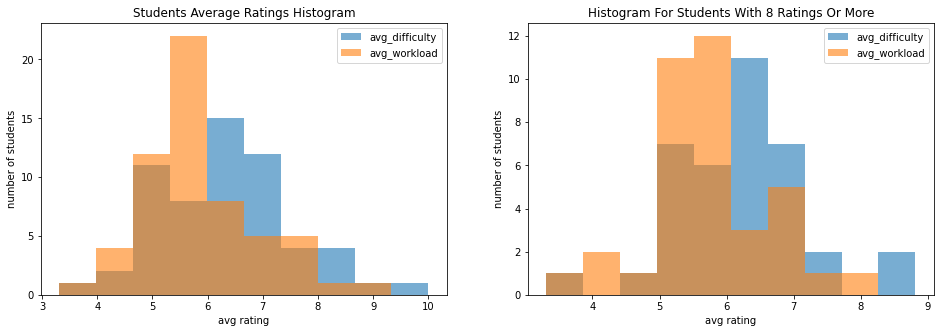

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[16,5],)

ax0 = users_df[["avg_difficulty", "avg_workload"]].plot.hist(ax=ax[0],
                                                        alpha=0.6,
                                                        title="Students Average Ratings Histogram")
ax0.set_xlabel("avg rating")
ax0.set_ylabel("number of students")

# make the same plot but only for users with more 8 ratings or more:
users_8_plus_df = users_df[users_df["ratings_count"] >= 8]
ax1 = users_8_plus_df[["avg_difficulty", "avg_workload"]].plot.hist(ax=ax[1],
                                                                      alpha=0.6,
                                                                      title="Histogram For Students With 8 Ratings Or More")
ax1.set_xlabel("avg rating")
ax1.set_ylabel("number of students")

### Ratings Range
Students are encouraged to use all the 1-10 scale in their votes in order to produce high quality data and to get better predictions. 
We are going to check how well they did, this time we only use the data of students with 8 ratings or more.
the maximum range is 9 (there is no 0 in the scale).

Text(0, 0.5, 'number of students')

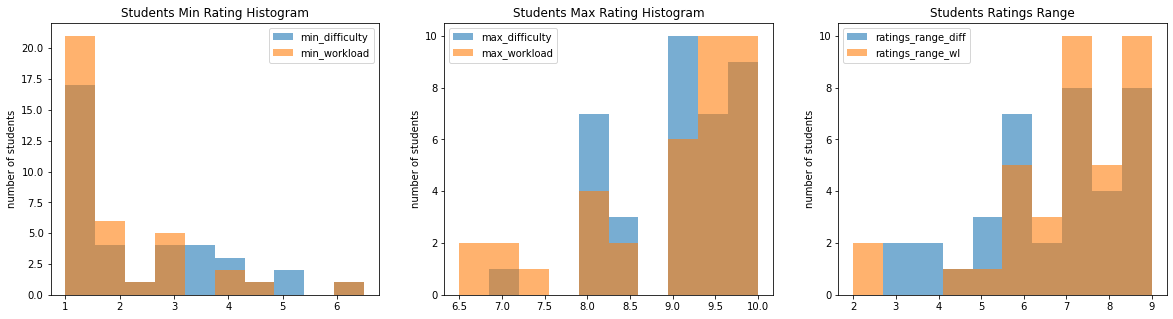

In [123]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[20,5],)

ax0 = users_8_plus_df[["min_difficulty", "min_workload"]].plot.hist(ax=ax[0],
                                                        alpha=0.6,
                                                        title="Students Min Rating Histogram")
ax0.set_ylabel("number of students")

ax1 = users_8_plus_df[["max_difficulty", "max_workload"]].plot.hist(ax=ax[1],
                                                                      alpha=0.6,
                                                                      title="Students Max Rating Histogram")
ax1.set_ylabel("number of students")

ax2 = users_8_plus_df[["ratings_range_diff", "ratings_range_wl"]].plot.hist(ax=ax[2],
                                                                      alpha=0.6,
                                                                      title="Students Ratings Range")
ax2.set_ylabel("number of students")

It seems that most of the students did well, but becasue some of the students did not use enough of the scale, we might want to normlize students ratings to 1-10 scale when performing algorithems on the data.

## Correlation Between Workload And Difficulty

In [124]:
corr = ratings_combined["workload"].corr(ratings_combined["difficulty"])
print("the correlation beetween workload and difficulty is", corr)

the correlation beetween workload and difficulty is 0.598543461791896


## Ratings Variances (And Standard Deviation)
We would also like to know what are the varicances of the courses ratings. Low variance on course ratings, means that most of the students think pretty much the same, and maybe predicting difficulty using ML algorithms is superfluous becase the average is a pretty good predictor for everyone. 
we will look at the 20 most rated courses. 

average std for difficulty: 1.4073870847942722
average std for workload: 1.3575180913270293


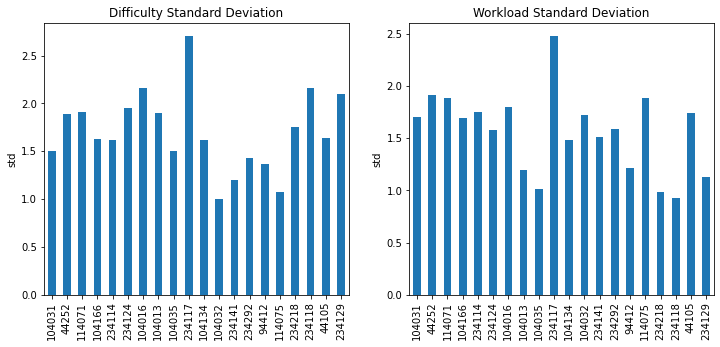

In [125]:
courses_df["var_diff"] = -1
courses_df["var_wl"] = -1

# we will calculate variance for all the courses anyway
for course in courses_df.index:
    one_course_ratings = ratings_combined[ratings_combined["course"] == course]
    variances = one_course_ratings.var()
    courses_df.loc[course, "var_diff"] = variances["difficulty"]
    courses_df.loc[course, "var_wl"] = variances["workload"]

# ignoring variance, we can get better conclution from the std
#
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[12,13])
# ax1 = courses_df["var_diff"].iloc[0:20].plot.bar(ax=ax[0,0],
#                                         title="Difficulty Variance",
#                                         ylabel="variance",)
# ax2 = courses_df["var_wl"].iloc[0:20].plot.bar(ax=ax[0,1],
#                                         title="Workload Variance",
#                                         ylabel="variance",)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12,5])

courses_df["std_diff"] = np.sqrt(courses_df["var_diff"])
courses_df["std_wl"] = np.sqrt(courses_df["var_wl"])

ax3 = courses_df["std_diff"].iloc[0:20].plot.bar(ax=ax[0],
                                        title="Difficulty Standard Deviation",
                                        ylabel="std",)
ax4 = courses_df["std_wl"].iloc[0:20].plot.bar(ax=ax[1],
                                        title="Workload Standard Deviation",
                                        ylabel="std",)

print("average std for difficulty:", courses_df["std_diff"].mean())
print("average std for workload:", courses_df["std_wl"].mean())

In most of the rated courses, the standad deviation is quite low: around 1.5 and there are some courses with very low value. but some courses has high variance of ratings and may be intrasting to predict for students or to be used for prediction.

234117 for example, "Introduction To Computer Science" is a first semester course which some students find hard and some easy. We could expect that student thinking this course is hard will think the same on other programming courses.



# Data Preparation
As mentioned earlier, we are not going to handle courses with one rating and at this point we are only going to handle students with less then 8 ratings (we will test this number later).

for performance reasons, our algorithms are going to work on numpy arrays and not on pandas dataframes.

The algorithms are going to get an $n$ x $2$ matrix and $n$ x $1$ vector as a training input because this is how the data is represented in our database. of course some of the algorithms are going to change the representation.

$X = \begin{pmatrix}
  u^{(1)} & c^{(1)} \\
  \vdots  & \vdots \\
  u^{(n)} & c^{(n)} 
 \end{pmatrix}$
 $ \mathbf y = \begin{pmatrix}
  y^{(1)}\\
  \vdots \\
  y^{(n)} 
 \end{pmatrix} $

each row is one rating while $u$ represents user, $c$ course and $y$ difficulty or workload. of course that for some $i \neq j $,  $u^{(i)} = u^{(j)} $ and same for course.

for prediction, the input will be **one** user and one course $\mathbf x = (u , c)$ and the out put will be an estimation for difficulty or workload $\mathbf{\hat y_{diff}}$ \ $\mathbf{\hat y_{wl}} $.

the prediction will be for one sample at a time although it may harm the perfomence when testing the algorithm here (a python function call for each sample instead of vectorized implementation), it is better for production, because at the website we are going to make one prediction at a time so we can optimize the algorithm for one prediction.






In [126]:
X_df = ratings_combined[["user", "course", "workload", "difficulty"]]
# X_df actually contains now both y vectors, they will be seperated 
# at convertion to numpy

# clean courses with less then 2 ratings:
courses_df_clean = courses_df[courses_df["ratings_count"] > 1]
X_df = X_df[X_df["course"].isin(courses_df_clean.index)]

# clean students with less then 8 ratings:
X_df = X_df[X_df["user"].isin(users_8_plus_df.index)]

print("we are left with", len(X_df), "samples")
print()

# convert to numpy:
X = X_df[["user", "course"]].to_numpy()
y_diff = X_df["difficulty"].to_numpy()
y_wl = X_df["workload"].to_numpy()

we are left with 523 samples



# Algorithm Metrics
## Defining The Problem
Given user U and course C, we would like to give an prediction for the difficulty and workload of C to U, using all the other ratings.
this is a **regression** problem.
In some cases the prediction is impossible, for example: the course U doesn't have any ratings at all. we could do something like giving a naive prediction of 5 or the mean rating in the data, but i prefer not to do that because it could harm the transparency of the metrics.
therefore, a prediction can be either a real number from 1 to 10 or a None which means the prediction was impossible.

## Metrics
We should define metrics to measure how good is a recommendation or set of recommedations.

The metrics are not going to combine difficulty and workload but be calculated for each prediction seperatly.

given a set of user ratings
 $ \mathbf{y} = \begin{pmatrix}
  y^{(1)} \\
  y^{(2)} \\
  \vdots \\
  y^{(n)}
  \end{pmatrix}$
and a set of predictions 
$\mathbf{\hat y} = \begin{pmatrix}
  \hat y^{(1)} \\
  \hat y^{(2)} \\
  \vdots \\
  \hat y^{(n)}
  \end{pmatrix}$ ,

we will define $l(y^{(i)}, \hat y^{(i)})$ as the loss function, an error function on one prediction and $E(\mathbf{y}, \mathbf{\hat y})$ as the error on the set.
<br><br>
### MAE
This is the most intuitive method. It measures the average prediction error on a set of prediction.

$l(y^{(i)}, \hat y^{(i)}) = |y^{(i)} - \hat y^{(i)}|$

$E(\mathbf{y}, \mathbf{\hat y}) = \frac{1}{n} \sum_{i=1}^n |y^{(i)} - \hat y^{(i)}| $

It is good method because it lets us know exactly the average of "how match we are wrong"
<br><br>
### RMSE
This method is very well known and widely used.
It measures the average root square error of the prediction.
$l(y^{(i)}, \hat y^{(i)}) = (y^{(i)} - \hat y^{(i)})^2$

$E(\mathbf{y}, \mathbf{\hat y}) = \frac{1}{n} \sum_{i=1}^n (y^{(i)} - \hat y^{(i)})^2 $

Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors on the set, so optimazing the RMSE will penalize large errors.
 <br><br>

 ### 1/2 loss missclasification rate
This method uses the MAE formula but returns a binary loss. it ignores errors lower then 0.5 and counts errors higher then that.

$l(y^{(i)}, \hat y^{(i)}) = \mathbb I\{|y^{(i)} - \hat y^{(i)}| > 0.5 \} \in \{0,1\}$

$E(\mathbf{y}, \mathbf{\hat y}) = \frac{1}{n} \sum_{i=1}^n \mathbb I\{|y^{(i)} - \hat y^{(i)}| > 0.5 \} \in [0,1]$

This method is usefull because it ignores low errors. optimizing it means we are maximizing the amount of right predictions, assuming that an up to 0.5 error is negligible. 
(if a student real value of difficulty is 6.5 for example, 6 to 7 are reasonable predictions)

In [127]:
from sklearn.metrics import mean_absolute_error as mae
mae.__name__ = "mae"
from sklearn.metrics import mean_squared_error
 
 
def rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))
 
 
def half_miss_rate(y, y_hat):
    """ half missclassification rate function for 2 numpy vectors """
    assert(len(y) == len(y_hat))
    loss_vector = np.absolute(y - y_hat) > 0.5
    return np.count_nonzero(loss_vector) / len(loss_vector)
 
 
assert(half_miss_rate(np.array([1,2,3]), np.array([1.3, 2.9, 3])) == 1/3)
assert(mae(np.array([1,2,3]), np.array([2, 3, 7])) == 2)
assert(rmse(np.array([1,1,1]), np.array([2, 2, 2])) == 1)

## Algorithm Evaluation
### 10-Fold For Test
Since our data is small and sparce, a simple 20-80 test-train split will not be enough. Also a 5-fold split leaves us with tarin sets which are too small and may not have enough common courses/users with the test sets. Therefore we will use 10-fold split for train set and test set. 
We can allow ourself to do that because training and testing 10 times will not take too long as the data is small.
 
For our first naive algorithms we don't need validation set becasue there are no parameters to tune, but we will make that split later.

In [128]:
from typing import Callable, List, Union
from sklearn.model_selection import KFold
 
 
# define generic algorithm for evaluator:
class GenericAlgorithm():
    def __init__(self):
        self.is_trained = False

    def train(self, X, y):
        assert(X.shape[0] == len(y))
        assert(X.shape[1] == 2)
        self.is_trained = True
 
    def predict(self, x):
        assert(len(x) == 2)
        assert(self.is_trained == True)
 
 
class AlgorithmEvaluator():
    def __init__(self,
                 num_of_folds: int, 
                 metric_functions: List[ Callable[[np.ndarray, np.ndarray], float] ]=
                                                           [mae, rmse, half_miss_rate],
                 random_seed: Union[None, int]=None):
        """
         Create algorithm evaluator that evaluate algorithms with num_of_folds
         folds and a list of metrics.
         metric_functions is list of functions, each of the function recives 
         two arrays (y and y_hat) and returns the error E.
        """
        self.metrics = metric_functions
        self.k = num_of_folds
        self.k_fold = KFold(n_splits=self.k,
                            shuffle=True,
                            random_state=random_seed)
        self.last_res = None
        
    def evaluate(self, 
                 algo :GenericAlgorithm,
                 X: np.ndarray,
                 y: np.ndarray) -> pd.DataFrame:
        """ 
        evaluate a given algorithm (with the methods train and predict), 
        returns table of the results of each fold as DataFrame
        """
        df_columns = ["fold", "n_train", "n_test", "n_was_impossible",]
        df_columns += [m.__name__ for m in self.metrics]
        res = pd.DataFrame(columns=df_columns)
 
        # itarate over folds 
        i_fold = 1  # fold counter
        for train_index, test_index in self.k_fold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
 
            algo.train(X_train, y_train)
            y_hat = np.array([algo.predict(x) for x in X_test])
 
            none_count = np.count_nonzero(y_hat == None)
            df_row = ["f" + str(i_fold), len(y_train), len(y_test), 
                      none_count]
 
            # remove none values from y and y_hat:
            numerical_indices = np.where(y_hat != None)
            y_test, y_hat = y_test[numerical_indices], y_hat[numerical_indices]
 
            df_row += [metric(y_test, y_hat) for metric in self.metrics]
 
            res.loc[i_fold] = df_row
 
            i_fold += 1
        
        # add last row as means:
        res.loc[i_fold] = res.mean()
        # res.loc[i_fold, ["fold", "n_train", "n_test"]] = ["AVG", '', '']
        res.loc[i_fold, "fold"] = ["AVG"]
        self.last_res = res
        return res
 
    def print_summery(self):
        print(self.last_res.iloc[self.k])

# Naive Algorithms
First, we will test some simple (and not very usefull) estimators. They are usefull for comparing to other algorithms and they results may be a good starting point to improve from.

## Course Mean 
Actualy, although this eatimator is simple, it is quite good for prediction. 
All it does in order to predict rating of user U for course C is return the mean rating of C in the data.
 
Formally:
 
$\hat R(U,C) = \frac{1}{|R_c|} \sum_{r \in R_c} r$
 
Where $R_C$ is the set of all ratings of C.
 
By the way, here the MAE should have around the same value as the mean S.T.D of courses we computed earlier.

In [129]:
class MeanRating(GenericAlgorithm):
    def __init__(self):
        super().__init__()
        self.x = None
        self.y = None
 
    def train(self, X, y):
        super().train(X, y)
        self.x = X[:,1] # we don't need to know the user
        self.y = y
        # this is a lazy implementation, we only calculate the average when 
        # a prediction is requested
 
    def predict(self, x):
        super().predict(x)
        if not x[1] in self.x:
             return None
        return self.y[self.x == x[1]].mean()

In [130]:
evaluator = AlgorithmEvaluator(10, random_seed=69**2)
algo = MeanRating()
print("difficulty evaluation")
evaluator.evaluate(algo, X, y_diff)

difficulty evaluation


,fold,n_train,n_test,n_was_impossible,mae,rmse,half_miss_rate
1,f1,470,53,1,1.759143,2.197034,0.807692
2,f2,470,53,0,1.183508,1.404227,0.773585
3,f3,470,53,5,1.426273,1.826645,0.770833
4,f4,471,52,0,1.536732,1.989648,0.692308
5,f5,471,52,0,1.458770,1.949137,0.711538
6,f6,471,52,1,1.414885,1.834381,0.666667
7,f7,471,52,5,1.466966,1.916166,0.808511
8,f8,471,52,2,1.825707,2.198589,0.860000
9,f9,471,52,0,1.493651,1.939531,0.750000
10,f10,471,52,0,1.368560,1.755525,0.730769


In [131]:
 print("workload evaluation")
evaluator.evaluate(algo, X, y_wl)

workload evaluation


,fold,n_train,n_test,n_was_impossible,mae,rmse,half_miss_rate
1,f1,470,53,1,1.734918,2.102399,0.788462
2,f2,470,53,0,1.205206,1.636124,0.641509
3,f3,470,53,5,1.597754,2.001928,0.729167
4,f4,471,52,0,1.625904,2.104761,0.750000
5,f5,471,52,0,1.234341,1.558802,0.653846
6,f6,471,52,1,1.163747,1.568457,0.627451
7,f7,471,52,5,1.745925,2.068449,0.893617
8,f8,471,52,2,1.573862,2.104274,0.740000
9,f9,471,52,0,1.522612,1.842543,0.769231
10,f10,471,52,0,1.469208,1.811815,0.807692


The reaults for both workload and difficulty in words:
* On an average case, according to the MAE we will have around 1.5 error in prediction
* Around 1/4 of prediction are within 0.5 error according to half missclassification rate
 
Those reaults may give us reference for other algorithms.

## Dummy Five
Before we go ahead, lets try one more naive algorithm. This one is even simpler but not very usefull.
No matter what the user, or the course we are predicting, it will return 5. Formally:
$\hat R(U,C) = 5$
 
We actually already know that the MAE can't be higher then 5 here (it would have been 5 if all ratings were 10).
 
This time we will only show the final reault and not all the folds.

In [132]:
 class DummyFive(GenericAlgorithm): 
    def __init__(self):
        super().__init__()
 
    def train(self, X, y):
        super().train(X, y)
 
    def predict(self, x):
        super().predict(x)
        return 5

In [133]:
evaluator = AlgorithmEvaluator(10, random_seed=69**2)
algo = DummyFive()
print("dificulty evaluation")
evaluator.evaluate(algo, X, y_diff)
evaluator.print_summery()
 
print()
print("workload evaluation")
evaluator.evaluate(algo, X, y_wl)
evaluator.print_summery()

dificulty evaluation
fold                     AVG
n_train                470.7
n_test                  52.3
n_was_impossible           0
mae                  2.15974
rmse                  2.5443
half_miss_rate      0.844848
Name: 11, dtype: object

workload evaluation
fold                    AVG
n_train               470.7
n_test                 52.3
n_was_impossible          0
mae                 1.99064
rmse                2.37536
half_miss_rate      0.81045
Name: 11, dtype: object


# KNN
KNN stands for K Nearest Neighbors. K is a parameter for the algorithm.

In the user based version, we find the k most similar users to U that rated the course C, calculate the mean of their rating for C and return the result as the prediction.

In the item based version (in our case course based), we find the k most similar courses to C that U rated, calculate the mean of ratings by U for those courses and return the result as the prediction.


## similarity
In order to use KNN, we have to define similarity beetween two users or courses. 
For the user case, similarity is a function $ S(U_1, U_2)$ that gets 2 users and return a number that indicates how similar they are.
There are several common similarity functions like euclidean distance and manhattan distance, but the one we are going to use is [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

the cosine similarity beetweeen two vectors $\mathbf{a} $ and $\mathbf{b} $ is defined : 

$S(\mathbf{a}, \mathbf{b}) 
=  \frac{\mathbf{a}^T \mathbf{b}}{||\mathbf{a}|||\bf{b}||} 
= \frac{\mathbf{a} \cdot \mathbf{b}}{||\mathbf{a}|||\mathbf{b}||}$

It returns a number between -1 and 1 which represents the angel beetween the two vectors in space, its quite inituitive in 2D.

But what are  the vectors in the case of two users? We could create a vector for each user for his ratings, but those vectors are going to be as long as the number of courses and sparce because each user rated a small fraction of the courses. Instead, we will calculate the similarity beetween two users in the common courses space. we will create vector for each of the two user where each component is his rating for a course they both rated. So the vector length will be the amount of common courses, this number will be defined as the support. Now we can define another parameter for the algorithm, the minimal support. 1 common course may be not enough to know for sure how two users are similar, therefore we might not want to use $U_1$ to predict $U_2$. 

Formally for the user based case : Let $R_i$ be the set of courses rated by $U_i$, and $R_{i,k}$ the rating of $U_i$ to course k. Then:

$S(U_i,U_j) = \frac{\sum_{k \in  R_i \cup R_j}R_{i,k} R_{j,k}}{\sqrt{ \sum_{k \in  R_i \cup R_j}R_{i,k}^2} \sqrt{ \sum_{k \in  R_i \cup R_j}R_{j,k}^2}}$

It is defined if $R_i \cup R_j > min\_support$

Luckily, we dont have to normalize the similarity becasue it is already normlized to [-1,1]. (well actualy to [0,1] since we dont have negative ratings (well actualy it cant be zero since we dont have a 0 rating)).

The prediction for a student and acourse is simply the mean of the k most similar users rating for this course. If there aren't students with ratings to this course who also have at least $min_support$ common courses with the predicted student, then the prediction is impossible for this algorithm.

Altough there is an efficient way to cumpute a similarity matrix that contains the similarity between every pari of users, we are not going to need it since we decided to optimize our algorithms to predict one user at a time therefore we only need a few similarities in each prediction.

In [134]:
class KNNGeneric(GenericAlgorithm): 
    def __init__(self, k=5, min_support=2):
        assert(k>=1)
        assert(min_support>=1)
        super().__init__()

        self.k = k
        self.X = None
        self.y = None
        self.min_support = min_support

    def train(self, X, y):
        super().train(X, y)
        self.X = X
        self.y = y
        # all the calculations are going to be done in predict
    
    def predict(self, x):
        super().predict(x)

### Implementation Of The User Based KNN:

In [135]:
import math
class KNNUser(KNNGeneric): 
    """
     this is also an expandable class for other user based KNN algorithms 
     which are going to use it's protected methods 
    """

    def __init__(self, k=5,  min_support=2):
        super().__init__(k, min_support)

    def _cosine_similarity(self, user1, user2):
            """
            compute the cosine similarity of two users using only courses they both
            rated. in order to do that the users must have at least self.min_support
            courses they both rated, otherwise None is returned.
            """
            # find all ratings indices for each user:
            u1_ratings_ind = np.where(self.X[:, 0] == user1)[0]
            u2_ratings_ind = np.where(self.X[:, 0] == user2)[0]
            X_u1 = self.X[u1_ratings_ind, :]
            X_u2 = self.X[u2_ratings_ind, :]
            y_u1 = self.y[u1_ratings_ind]
            y_u2 = self.y[u2_ratings_ind]

            # get the common courses and their indices in each users rating array
            common_courses, u1_ind_common, u2_ind_common = np.intersect1d(X_u1[:,1],
                                                                        X_u2[:,1],
                                                                        assume_unique=True,
                                                                        return_indices=True)
            # check support is large enough:
            if not len(common_courses) >= self.min_support:
                return None

            # create vectors for each user in the common courses space:
            y_u1_common = y_u1[u1_ind_common]
            y_u2_common = y_u2[u2_ind_common]
                
            # return cosine similarity in that space:
            return np.inner(y_u1_common, y_u2_common) / (np.linalg.norm(y_u1_common)*
                                                        np.linalg.norm(y_u2_common))
            
    def _compute_similarities(self, user, course):
        """
        *if no other users rated the course a None is returned* 
        
        this method gets user and course to predict, and finds the potential
        neighbors as an array with three rows:
        user_similarities[0] are the users rated the course
        user_similarities[1] are thier similarities to user
        user_similarities[2] are thier ratings to the course

        *in case the similarity was impossible to compute it is -1 in the array*
        
        this data is is used in predict
        """
        # find all rating for this course and all the raters:
        course_ratings_indices = np.where(self.X[:,1] == course)
        X_course = self.X[course_ratings_indices, :][0]
        y_course = self.y[course_ratings_indices]
        users_rated_course = X_course[:, 0]
        # the useres are sorted by their location on X_course and y_course

        if len(users_rated_course) == 0:
            return None

        # compute similaritiy between predicted user and each of the users rated
        # the course
        cosine_sim_vectorized = np.vectorize(self._cosine_similarity)
        similarities = cosine_sim_vectorized(users_rated_course, user)
        np.nan_to_num(similarities, nan=-1, copy=False)
        similarities[similarities == None] = -1

        user_similarities = [users_rated_course,
                             similarities,
                             y_course]
        user_similarities = np.array(user_similarities)

        return user_similarities

    def _get_knn_for_course(self, user, course):
        """
        returns neighbors vector with 3 rows and min(k,n_of_neighbors_for_this course) collumns:
        neighbors_vec[0] are the neighbors (users_id)
        neighbors_vec[1] are thier similarities to user
        neighbors_vec[2] are thier ratings to the course
        None is returned if there are no neighbors for this course
        """
        if user not in X[:,0]:
            print("user", user, "has no ratings in the train set")
            return None
        
        user_similarities = self._compute_similarities(user, course)
        if user_similarities is None:
            # no other users rated that course
            return None

        total_neighbors = len((user_similarities[1])[user_similarities[1]> 0])

        if total_neighbors < 1:
            # no other users rated that course with min_support
            return None

        if total_neighbors <= self.k:
            # there are exactly k users or less so they are all neighbors
            neighbors_indices = tuple(np.where(user_similarities[1] > 0)[0])
        else:
            neighbors_indices = tuple(
                np.argpartition(user_similarities[1], -self.k)[-self.k:])
            
        
        neighbors_vec = user_similarities[:,neighbors_indices]
        return neighbors_vec

    def predict(self, x):
        super().predict(x)
        user, course = x[0], x[1]

        neighbors_vec = self._get_knn_for_course(user, course)
        if neighbors_vec is None:
            return None
        
        y_course = neighbors_vec[2, :]
        return y_course.mean()

Lets evaluate the algorithm with the same folds :

In [136]:
algo = KNNUser(k=5,min_support=2)
evaluator.evaluate(algo, X, y_diff)
print("difficulty:")
evaluator.print_summery()
print()

print("workload:")
evaluator.evaluate(algo, X, y_wl)
evaluator.print_summery()

difficulty:
fold                     AVG
n_train                470.7
n_test                  52.3
n_was_impossible         4.2
mae                  1.43409
rmse                 1.83611
half_miss_rate      0.731071
Name: 11, dtype: object

workload:
fold                     AVG
n_train                470.7
n_test                  52.3
n_was_impossible         4.2
mae                  1.45167
rmse                 1.84905
half_miss_rate      0.715127
Name: 11, dtype: object


We got a slightly better results then Mean Rating. Of course we will have to find the best parameters $k$ and $min\_support$ but we will do it soon after a few improvments. We also notice that the amount of impossible prediction is slightly higher due to the $min\_support$. Increasing the $min\_support$ wil increase the number of impossible predictions.

### Implementation Of The Item Based KNN
This time we will look for similar courses for prediction.

The item based approach works better for some application but it is not expected to work well for us. Users in our data tend to be more similar to some other user then items are to items. for example - users from the same faculty should be similar and have many neighbors.

In [137]:
class KNNCourse(KNNGeneric): 

    def _cosine_similarity(self, course1, course2):
            """
            compute the cosine similarity of two courses using only users rated 
            them both. in order to do that the courses must have at least self.min_support
            common users, otherwise None is returned.
            """
            # find all ratings indices for each user:
            c1_ratings_ind = np.where(self.X[:, 1] == course1)[0]
            c2_ratings_ind = np.where(self.X[:, 1] == course2)[0]
            X_c1 = self.X[c1_ratings_ind, :]
            X_c2 = self.X[c2_ratings_ind, :]
            y_c1 = self.y[c1_ratings_ind]
            y_c2 = self.y[c2_ratings_ind]

            # get the common users and their indices in each course rating array
            common_users, c1_ind_common, c2_ind_common = np.intersect1d(X_c1[:,0],
                                                                        X_c2[:,0],
                                                                        assume_unique=True,
                                                                        return_indices=True)
            # check support is large enough:
            if not len(common_users) >= self.min_support:
                return None

            # create vectors for each course in the common users space:
            y_c1_common = y_c1[c1_ind_common]
            y_c2_common = y_c2[c2_ind_common]
                
            # return cosine similarity in that space:
            return np.inner(y_c1_common, y_c2_common) / (np.linalg.norm(y_c1_common)*
                                                        np.linalg.norm(y_c2_common))
            
    def predict(self, x):
        super().predict(x)
        user, course = x[0], x[1]

        if course not in X[:,1]:
            print("course", course, "has no ratings in the train set")
            return None

        # find all ratings by this user and all the courses he rated:
        user_ratings_indices = np.where(self.X[:,0] == user)
        X_user = self.X[user_ratings_indices, :][0]
        y_user = self.y[user_ratings_indices]
        courses_rated_by_user = X_user[:, 1]
        # the courses are sorted by their location on X_user and y_user

        if len(courses_rated_by_user) == 0:
            return None

        # compute similaritiy between predicted course and each of the courses 
        # rated by the user
        cosine_sim_vectorized = np.vectorize(self._cosine_similarity)
        similarities = cosine_sim_vectorized(courses_rated_by_user, course)

        total_neighbors = len(similarities[similarities != None])

        if total_neighbors == 0:
            # impossible to predict for this user
            return None 
        elif total_neighbors <= self.k:
            neighbors_indices = np.where(similarities != None)
        else:
            similarities[similarities == None] = -1
            neighbors_indices = np.argpartition(similarities, -self.k)[-self.k:]
            # neighbors = courses_rated_by_user[neighbors_indices]

        return y_user[neighbors_indices].mean()

In [138]:
algo = KNNCourse(k=3, min_support=2)
print("difficulty:")
evaluator.evaluate(algo, X, y_diff)
evaluator.print_summery()
print()
 
print("workload:")
evaluator.evaluate(algo, X, y_wl)
evaluator.print_summery()

difficulty:
fold                     AVG
n_train                470.7
n_test                  52.3
n_was_impossible        11.6
mae                  1.97308
rmse                 2.43662
half_miss_rate      0.813333
Name: 11, dtype: object

workload:
fold                     AVG
n_train                470.7
n_test                  52.3
n_was_impossible        11.6
mae                  2.05835
rmse                 2.53287
half_miss_rate      0.844673
Name: 11, dtype: object


We got some poor results, just a little bit better then DummyFive and even worse then CourseMean. So we will stick with user based and try to improve it.

## wighted KNN
In KNN  we found the k most similar users to our user and averaged them, but we gave each of them the same weight (which is $1/k$) ignoring the aimilarity value.
In weighted KNN we give each of the K users a weight based on his similarity to the predicted user, which may improve our reaults.
 
Formaךly:
We find the K neareat neighbors  $\{U\}_1^k$ to U that rated courae C. Then:
 
$\hat R (U,C) = \frac{\sum_{i=1}^KS(U,U_i) \cdot R(U_i)}{ \sum_{i=1}^KS(U,U_i) }$

In [139]:
class WeightedKNN(KNNUser): 
 
    def predict(self, x):
        KNNGeneric.predict(self, x)
        user, course = x[0], x[1]
 
        neighbors_vec = self._get_knn_for_course(user, course)
        if neighbors_vec is None:
            return None
        
        similarities = neighbors_vec[1, :]
        y_course = neighbors_vec[2, :]
        
        return np.inner(similarities, y_course) / np.sum(similarities)

 ## Choosing K And min_support
Before we go on comparing the algorithms, we need to find rhe best parameters for each of them. Since we are going to nees the 10-folds for cross validation we have no escape from allocating some of our data to the test set. Then we will use the 10-fold cross validation on our train set and compare beetween different algorithms and meaure our reaults on the test set.

In [140]:
test_set_size = 0.2
 
rand = np.random.RandomState(42*7)
indices = np.arange(len(X))
rand.shuffle(indices)
 
slice_point = int(np.floor(test_set_size*len(X)))
test_set_indices = indices[0:slice_point]
train_set_indices = indices[slice_point: len(X)]
 
X_test = X[test_set_indices]
X_train = X[train_set_indices]
y_diff_test = y_diff[test_set_indices]
y_diff_train = y_diff[train_set_indices]
y_wl_test = y_wl[test_set_indices]
y_wl_train = y_wl[train_set_indices]
 
print("test set length:", len(X_test))
print("train set length:", len(X_train))

test set length: 104
train set length: 419


In [141]:
# add test set evaluation to the evaluator class
def evaluator_test_score(self,
                         algo :GenericAlgorithm,
                         X_train: np.ndarray,
                         y_train: np.ndarray,
                         X_test: np.ndarray,
                         y_test: np.ndarray,):
    """
    evaluate algorithms scores given an explicit test set and train set
    """
    algo.train(X_train, y_train)
    y_hat = np.array([algo.predict(x) for x in X_test])
 
    #save the none count
    none_count = np.count_nonzero(y_hat == None)
 
    # remove none values from y and y_hat:
    numerical_indices = np.where(y_hat != None)
    y_test_clean, y_hat_clean = y_test[numerical_indices], y_hat[numerical_indices]
    
    for metric in self.metrics:
        print(metric.__name__, ":", metric(y_test_clean, y_hat_clean))
    
    print("was imposibole :", none_count, " (out of", len(y_test), ")")
 
AlgorithmEvaluator.test_score = evaluator_test_score

Test (only for difficulty) on algorithms before choosing parameters:

In [142]:
algo_mean_ratings = MeanRating()
print("mean ratings:")
evaluator.test_score(algo_mean_ratings, X_train, y_diff_train, X_test, y_diff_test)
print()
 
algo_knn = KNNUser()
print("KNN:")
evaluator.test_score(algo_knn, X_train, y_diff_train, X_test, y_diff_test)
print()
 
print("KNN with weights:")
algo_weighted_knn = WeightedKNN()
evaluator.test_score(algo_weighted_knn, X_train, y_diff_train, X_test, y_diff_test)

mean ratings:
mae : 1.4476530847624598
rmse : 1.879265233032012
half_miss_rate : 0.71875
was imposibole : 8  (out of 104 )

KNN:
mae : 1.393173758865248
rmse : 1.8441350471437874
half_miss_rate : 0.7021276595744681
was imposibole : 10  (out of 104 )

KNN with weights:
mae : 1.393045753324717
rmse : 1.8437124100521258
half_miss_rate : 0.7127659574468085
was imposibole : 10  (out of 104 )


 ### testing different parameters
We have to search the best parameters from a very small set.
 
K is an integer, and it is reasonable to check the numbers from 1 to 10. A number higher then that will includa **all** of the neighbors for that user in most cases.
 
$min\_support$ is also an integer and the reasonable values are 1 to 5. With a value higher then that too many predictions will be impossible or based on one neighbor becasue there are not enough users in the data for it to be likely that two users have more then 5 common courses.
 
This makes only 50 parameters combinations to check. With a small scale data as ours, we can easly try all combination. Since there are just two parameters we can easily plot the reaults and decide which parameters are the best.
 
We are going to look at:
* MAE which is the most simple metric
* Half Missclasification Rate which is an important metric for us as expained earlier
* The rate of impossible prediction from the validation set, which going to reflect the min support trade off and we also want to minimize it
 
We will use a 10-fold cross validation here.

In [143]:
def parameter_grid_evaluate_knn(AlgoType, X, y, k_vals, min_support_vals):
    """
    evaluates the algorithm with 10 folds for each pair of paramters
    from k_vals, min_support_vals and returns three grids (matrices) with
    the results. the first matrix is for mae, the second one is for 
    half missclassification rate and the third one is the precentege of the
    samples in the validation set that was impossible to predict
    """
    evaluator = AlgorithmEvaluator(10, [mae, half_miss_rate], 2021)
 
    mae_grid = np.zeros([len(k_vals), len(min_support_vals)])
    half_mr_grid = np.zeros([len(k_vals), len(min_support_vals)])
    percent_impossible_grid = np.zeros([len(k_vals), len(min_support_vals)])
 
    for i_k in range(len(k_vals)):
        for i_ms in range(len(min_support_vals)):
            algo = AlgoType(k=k_vals[i_k], min_support=min_support_vals[i_ms])
            res_df = evaluator.evaluate(algo, X, y)
            mae_grid[i_k,i_ms] = res_df.iloc[10]["mae"]  # avrage is in iloc[10]
            half_mr_grid[i_k,i_ms] = res_df.iloc[10]["half_miss_rate"]
            percent_impossible_grid[i_k,i_ms] = \
                res_df.iloc[10]["n_was_impossible"] / float(res_df.iloc[10]["n_test"])
 
    return mae_grid, half_mr_grid, percent_impossible_grid
 
def heat_map_params_plot(mae_grid, half_mr_grid, percent_impossible_grid, 
                        k_vals ,min_support_vals, algo_name,):
    grids = [mae_grid, half_mr_grid, percent_impossible_grid]
    axes = [None, None, None]  # mae, hmr, impossible
    fig,  axes = plt.subplots(1, 3, figsize=[10,5])
    fig.suptitle(algo_name, fontsize=16)
 
    axes[0].set_title("MAE")
    axes[1].set_title("Half Missclassification Rate")
    axes[2].set_title("Impossible Predictions Rate")
 
    for i_ax in range(3):
        axes[i_ax].set_xticks(np.arange(len(min_support_vals)))
        axes[i_ax].set_xticklabels(min_support_vals)
        axes[i_ax].set_xlabel("min support")
 
        axes[i_ax].set_yticks(np.arange(len(k_vals)))
        axes[i_ax].set_yticklabels(k_vals)
        axes[i_ax].set_ylabel("K")
 
        im = axes[i_ax].imshow(grids[i_ax])
 
        for i in range(len(k_vals)):
            for j in range(len(min_support_vals)):
                text = axes[i_ax].text(j, i, round((grids[i_ax])[i, j], 2),
                            ha="center", va="center", color="w")

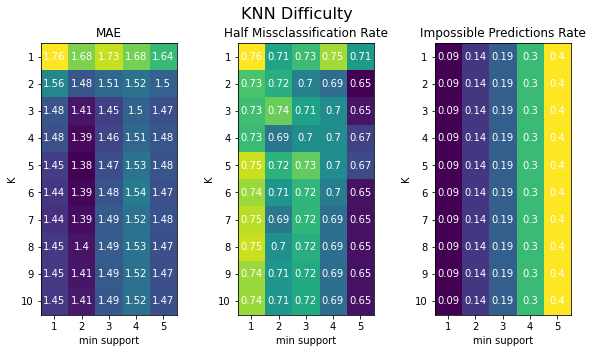

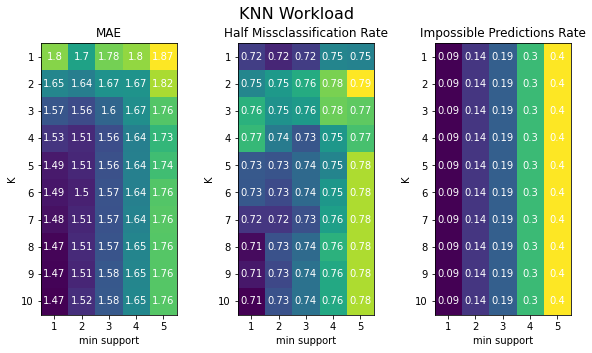

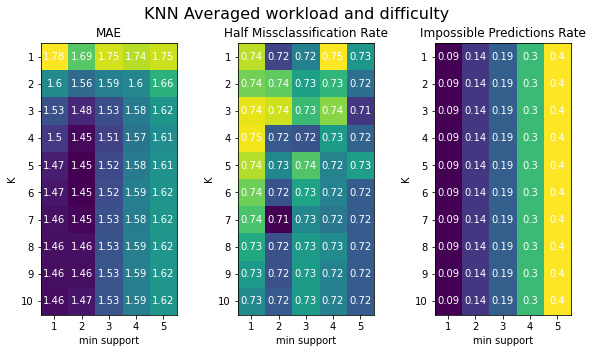

In [144]:
k_vals = np.arange(1,11)
min_support_vals = np.arange(1,6)
 
mae_grid_d, half_mr_grid_d, percent_impossible_grid_d =\
    parameter_grid_evaluate_knn(KNNUser, X_train, y_diff_train, k_vals, min_support_vals)
 
heat_map_params_plot(mae_grid_d, half_mr_grid_d, percent_impossible_grid_d,
                     k_vals ,min_support_vals, "KNN Difficulty")
 
mae_grid_w, half_mr_grid_w, percent_impossible_grid_w =\
    parameter_grid_evaluate_knn(KNNUser, X_train, y_wl_train, k_vals, min_support_vals)
 
heat_map_params_plot(mae_grid_w, half_mr_grid_w, percent_impossible_grid_w,
                     k_vals ,min_support_vals, "KNN Workload")
 
mae_grid_avg = (mae_grid_d + mae_grid_w)/2
half_mr_grid_avg = (half_mr_grid_d + half_mr_grid_w)/2
percent_impossible_grid_avg = (percent_impossible_grid_d + percent_impossible_grid_w)/2
 
heat_map_params_plot(mae_grid_avg, half_mr_grid_avg, percent_impossible_grid_avg,
                     k_vals ,min_support_vals, "KNN Averaged workload and difficulty")

It seems that the best values are $k = 7$ and $min\_support = 2$.
there are some better values for $min\_support$ but the impossible predictions rate is too high.
 
From now we will only plot the avarage of workload and difficulty:

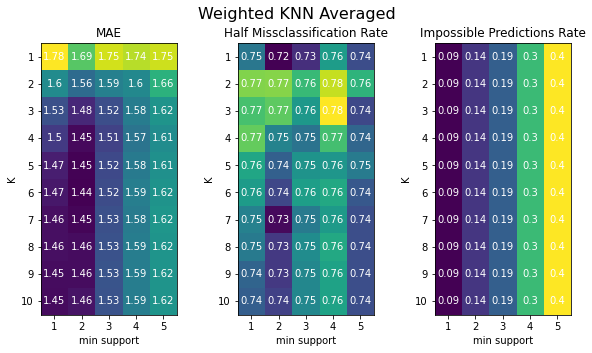

In [145]:
mae_grid_d, half_mr_grid_d, percent_impossible_grid_d =\
    parameter_grid_evaluate_knn(WeightedKNN, X_train, y_diff_train, k_vals, min_support_vals)
 
# heat_map_params_plot(mae_grid_d, half_mr_grid_d, percent_impossible_grid_d,
#                      k_vals ,min_support_vals, "Weighted KNN Difficulty")
 
mae_grid_w, half_mr_grid_w, percent_impossible_grid_w =\
    parameter_grid_evaluate_knn(WeightedKNN, X_train, y_wl_train, k_vals, min_support_vals)
 
# heat_map_params_plot(mae_grid_w, half_mr_grid_w, percent_impossible_grid_w,
#                      k_vals ,min_support_vals, "Weighted KNN Workload")
 
mae_grid_avg = (mae_grid_d + mae_grid_w)/2
half_mr_grid_avg = (half_mr_grid_d + half_mr_grid_w)/2
percent_impossible_grid_avg = (percent_impossible_grid_d + percent_impossible_grid_w)/2
 
heat_map_params_plot(mae_grid_avg, half_mr_grid_avg, percent_impossible_grid_avg,
                     k_vals ,min_support_vals, "Weighted KNN Averaged")

Here we got the same optimal values.
 
Lets check how well we perform on the teat set:

In [146]:
best_knn_k = 7
best_knn_min_support = 2
 
best_weighted_knn_k = 7
best_weighted_knn_min_support = 2
 
algo_knn = KNNUser(best_knn_k, best_knn_min_support)
print("KNN:")
print("-----")
print("-difficulty:")
evaluator.test_score(algo_knn, X_train, y_diff_train, X_test, y_diff_test)
print("-workload:")
evaluator.test_score(algo_knn, X_train, y_wl_train, X_test, y_wl_test)
print()
 
print("KNN with weights:")
print("-----")
algo_weighted_knn = WeightedKNN(best_weighted_knn_k, best_weighted_knn_min_support)
print("-difficulty:")
evaluator.test_score(algo_weighted_knn, X_train, y_diff_train, X_test, y_diff_test)
print("-workload:")
evaluator.test_score(algo_weighted_knn, X_train, y_wl_train, X_test, y_wl_test)

KNN:
-----
-difficulty:
mae : 1.4421605876393109
rmse : 1.8844285182967995
half_miss_rate : 0.7021276595744681
was imposibole : 10  (out of 104 )
-workload:
mae : 1.4156155015197567
rmse : 1.7852309587378572
half_miss_rate : 0.7446808510638298
was imposibole : 10  (out of 104 )

KNN with weights:
-----
-difficulty:
mae : 1.4409085685278122
rmse : 1.8819582636646113
half_miss_rate : 0.7340425531914894
was imposibole : 10  (out of 104 )
-workload:
mae : 1.4164631017794376
rmse : 1.7870142508844167
half_miss_rate : 0.7553191489361702
was imposibole : 10  (out of 104 )


Contrary to expectations, adding weights didn't show improvement in any metric.

# KNN With Bias


## Bias From Neighbors
Altough the user based KNN with cosine similarity uses the most similar users to predict course for user, it doesn't necessarily take into account the tendencies of some users to higher or lower ratings.
In our initial analysis we showed that the average rating per user is  Gaussian distributed and few users has different average then the others. Those useres are probably difficult to predict because there are not enough of them to find similar users that rated the same courses. for example, there is one user with mean rating of 8, when we try to predict a course for him, most of his chosen neighbors will probably have lower mean rating, and when we compute the mean rating of them for the course, the prediction might be to low because the user and his neighbors have "different definition for a high rating". We are going to try to fix that by biasing that users prediction by his standard diviation from the others.

Formally, given the k nearest neighbors 

$\begin{pmatrix}
  Neighbor^{(1)} \\
  Neighbor^{(2)} \\
  \vdots \\
  Neighbor^{(k)}
  \end{pmatrix}$ 

we find the mean of all their ratings :

$ \mathbf{\mu_{neighbors}} = \begin{pmatrix}
  \mu^{(1)} \\
  \mu^{(2)} \\
  \vdots \\
  \mu^{(n)}
  \end{pmatrix}$

and the mean of their means:

 $\bar \mu = \mathbb E[ \mathbf{\mu_{neighbors}}]$
 
Then, for the mean of the predicted user U: $\mu_U $ we define his bias:
<h3>
$Bias_U = \mu_U - \bar \mu$
</h3>
There is also a new hyper parameter $ w_{bias} $ for the bias weight.
finaly:

$\hat R_{biased}(U,C) = R_{knn}(U,C) + w_{bias} \cdot Bias_U$

and the result is thresholed with maximum of 10 and minimum of 1 of course

In [147]:
class KNNWithNeighborsBias(KNNUser): 
    def __init__(self, k=5,  min_support=2, bias_weight=1):
        super().__init__(k, min_support)
        self.bias_weight = bias_weight
 
    def _user_mean_rating(self, user):
        return self.y[np.where(self.X[:,0] == user)].mean()
 
    def predict(self, x):
        KNNGeneric.predict(self, x)
        user, course = x[0], x[1]
 
        neighbors_vec = self._get_knn_for_course(user, course)
        if neighbors_vec is None:
            return None
        
        neighbors_users = neighbors_vec[0, :]
        similarities = neighbors_vec[1, :]
        y_course = neighbors_vec[2, :]
 
        knn_prediction = y_course.mean()
 
        user_mean_rating_vectorized = np.vectorize(self._user_mean_rating)
        bias = self._user_mean_rating(user) - user_mean_rating_vectorized(neighbors_users).mean()
 
        res = knn_prediction + self.bias_weight*bias
        # threshold:
        if res > 10 :
            res = 10
        elif res < 1:
            res = 1
            
        return res

Lets look at $k$ and $min\_support$ values (with constant bias weight)

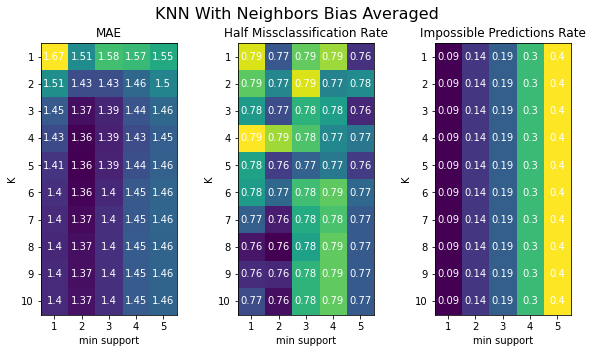

In [148]:
mae_grid_d, half_mr_grid_d, percent_impossible_grid_d =\
    parameter_grid_evaluate_knn(KNNWithNeighborsBias, X_train, y_diff_train, k_vals, min_support_vals)

mae_grid_w, half_mr_grid_w, percent_impossible_grid_w =\
    parameter_grid_evaluate_knn(KNNWithNeighborsBias, X_train, y_wl_train, k_vals, min_support_vals)

mae_grid_avg = (mae_grid_d + mae_grid_w)/2
half_mr_grid_avg = (half_mr_grid_d + half_mr_grid_w)/2
percent_impossible_grid_avg = (percent_impossible_grid_d + percent_impossible_grid_w)/2

heat_map_params_plot(mae_grid_avg, half_mr_grid_avg, percent_impossible_grid_avg,
                     k_vals ,min_support_vals, "KNN With Neighbors Bias Averaged")

We got the same best $k$ and $min\_support$ again. From now on we will assume this are the best values.

Now we have to find the best bias weight

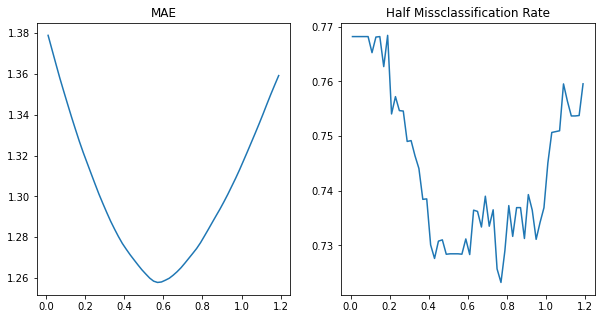

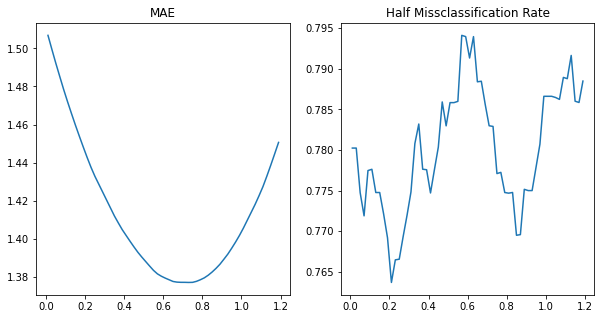

In [149]:
def evaluate_bias_weights(AlgoType, X, y, bias_weight_vals, k, min_support):
    """
     10-fold cross validates biased knn algorithms with constant k and 
     min support and a set of bias weight values. plots the results.
    """
    evaluator = AlgorithmEvaluator(10, [mae, half_miss_rate], 2021)
    res_mae = []
    res_hmr = []

    for val in bias_weight_vals:
        algo = AlgoType(bias_weight=val)
        res_df = evaluator.evaluate(algo, X, y)
        res_mae.append(res_df.iloc[10]["mae"])
        res_hmr.append(res_df.iloc[10]["half_miss_rate"])

    fig,  axes = plt.subplots(1, 2)
    axes[0].set_title("MAE")
    axes[0].plot(bias_weight_vals, res_mae)

    axes[1].set_title("Half Missclassification Rate")
    axes[1].plot(bias_weight_vals, res_hmr)

bias_weight_vals = np.arange(0.01, 1.2, 0.02)

evaluate_bias_weights(KNNWithNeighborsBias, X_train, y_diff_train, 
                      bias_weight_vals, 7, 2)
evaluate_bias_weights(KNNWithNeighborsBias, X_train, y_wl_train, 
                      bias_weight_vals, 7, 2)

The MAE is pretty smooth and has a clear global optimum. The HMR is a little bit noisy but has an optimum around the same point as MAE for both difficulty and workload.

Lets test those values on the test set:

In [150]:
print("KNN with neighbors bias:")
print("-----")
algo_biased_diff = KNNWithNeighborsBias(7,2,0.8)
print("-difficulty:")
evaluator.test_score(algo_biased_diff, X_train, y_diff_train, X_test, y_diff_test)

algo_biased_wl = KNNWithNeighborsBias(7,2,0.8)
print("-workload:")
evaluator.test_score(algo_biased_diff, X_train, y_wl_train, X_test, y_wl_test)

KNN with neighbors bias:
-----
-difficulty:
mae : 1.3662821953430315
rmse : 1.749613583349257
half_miss_rate : 0.7659574468085106
was imposibole : 10  (out of 104 )
-workload:
mae : 1.2483706599731332
rmse : 1.5594745368621428
half_miss_rate : 0.7978723404255319
was imposibole : 10  (out of 104 )


We have achieved significant improvement in mae but not in HMR.

## Bias From All Users
In the last algorithm, we tried to fix user bias from the chosen neighbors. maybe we can do better by generalizing it and compute the bias for each user from all of the users instead of it's neighbors. That means we find his location on the gaussian distribution of the users we showed earlier, and define his bias as his distance from the mean.

For each user $U_i$ we find his mean rating $\mu_i$, then we compute the mean mean rating $\bar \mu = \frac{1}{n} \sum_{i=1}^n \mu_i $ and the bias for user u will be:

$Bias_U = \mu_U - \bar \mu$

The prediction will be the same with the new bias:

$\hat R_{biased}(U,C) = R_{knn}(U,C) + w_{bias} \cdot Bias_U$

___ 
Note that when training the algorithm we compute the mean rating for each user which can take some time. In production, it's easy to maintain a mean rating for each user and incremental update it every time a user adds or changes a rating, so it will be more efficient.

In [151]:
class KNNWithUserBias(KNNUser): 
    def __init__(self, k=7,  min_support=2, bias_weight=1):
        super().__init__(k, min_support)
        self.bias_weight = bias_weight
        self.users_means = dict()
        self.mean_mean_rating = None
    
    def train(self, X, y):
        super().train(X, y)
        # since we are computing all users means anyway, we are going to save
        # them in a dictionary. in production we are going to get the values
        # from the database and update it incrementaly every time user rates
        users = np.unique(X[:,0])
        for user in users:
            self.users_means[user] = y[ X[:,0] == user ].mean()

        self.mean_mean_rating = sum(self.users_means.values()) / len(self.users_means)

    def predict(self, x):
        KNNGeneric.predict(self, x)
        user, course = x[0], x[1]

        neighbors_vec = self._get_knn_for_course(user, course)
        if neighbors_vec is None:
            return None
        
        neighbors_users = neighbors_vec[0, :]
        similarities = neighbors_vec[1, :]
        y_course = neighbors_vec[2, :]

        knn_prediction = y_course.mean()
        bias = self.users_means[user] - self.mean_mean_rating

        res = knn_prediction + self.bias_weight*bias
        # threshold:
        if res > 10 :
            res = 10
        elif res < 1:
            res = 1
            
        return res

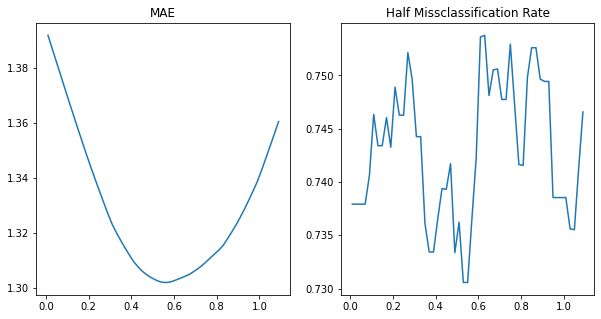

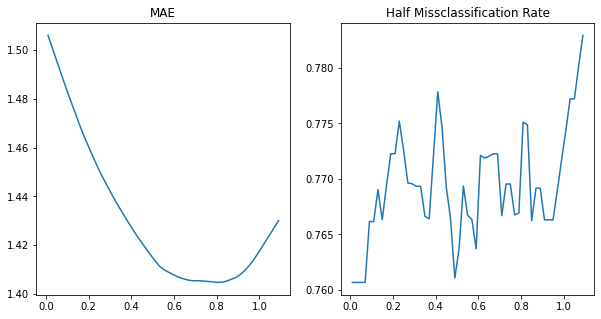

In [152]:
bias_weight_vals = np.arange(0.01, 1.1, 0.02)

evaluate_bias_weights(KNNWithUserBias, X_train, y_diff_train, 
                      bias_weight_vals, 7, 2)
evaluate_bias_weights(KNNWithUserBias, X_train, y_wl_train, 
                      bias_weight_vals, 7, 2)

In [153]:
print("KNN with user bias:")
print("-----")
algo_biased_diff = KNNWithNeighborsBias(7,2,0.55)
print("-difficulty:")

evaluator.test_score(algo_biased_diff, X_train, y_diff_train, X_test, y_diff_test)
algo_biased_wl = KNNWithNeighborsBias(7,2,0.55)
print("-workload:")
evaluator.test_score(algo_biased_diff, X_train, y_wl_train, X_test, y_wl_test)

KNN with user bias:
-----
-difficulty:
mae : 1.3453110065078189
rmse : 1.7514208502320627
half_miss_rate : 0.7340425531914894
was imposibole : 10  (out of 104 )
-workload:
mae : 1.2609546561506764
rmse : 1.576515254359014
half_miss_rate : 0.776595744680851
was imposibole : 10  (out of 104 )


We achieved some improvment buy HMR is still high.

## All User Bias
We tried to take into considiration the predicted user bias, but biased user may still affect our results when they are chosen as neighbors. To solve that, each rating can be updated with the bias that maches the user, an the new ratings are going to be used for predictions.

For each rating $R_{U_i,C}$ we update our dataset with the rating:

$\tilde R_{U_i,C} = R_{U_i,C} + w_{bias} \cdot Bias_{U_i}$

Then we use the new ratings $\tilde R$ for our predictions.

In [154]:
class KNNWithAllUsersBias(KNNUser): 
    def __init__(self, k=7,  min_support=2, bias_weight=1):
        super().__init__(k, min_support)
        self.bias_weight = bias_weight
        self.users_means = dict()
        self.mean_mean_rating = None
        self.y_old = None
    
    def train(self, X, y):
        super().train(X, y)
        # since we are computing all users means anyway, we are going to save
        # them in a dictionary. in production we are going to get the values
        # from the database and update it incrementaly every time user rates
        users = np.unique(X[:,0])
        for user in users:
            self.users_means[user] = y[ X[:,0] == user ].mean()

        self.mean_mean_rating = sum(self.users_means.values()) / len(self.users_means)

        biases = self.mean_mean_rating - np.array([self.users_means[X[i,0]] 
                                                   for i in range(len(y))])

        self.y_old = np.copy(y)
        self.y = y + biases*self.bias_weight
        self.y[self.y>10] = 10
        self.y[self.y<1] = 1

    def predict(self, x):
        KNNGeneric.predict(self, x)
        user, course = x[0], x[1]

        neighbors_vec = self._get_knn_for_course(user, course)
        if neighbors_vec is None:
            return None
        
        neighbors_users = neighbors_vec[0, :]
        similarities = neighbors_vec[1, :]
        y_course = neighbors_vec[2, :]
                
        knn_prediction = y_course.mean()
        bias = self.users_means[user] - self.mean_mean_rating

        res = knn_prediction + bias * self.bias_weight
        # threshold:
        if res > 10 :
            res = 10
        elif res < 1:
            res = 1
            
        return res

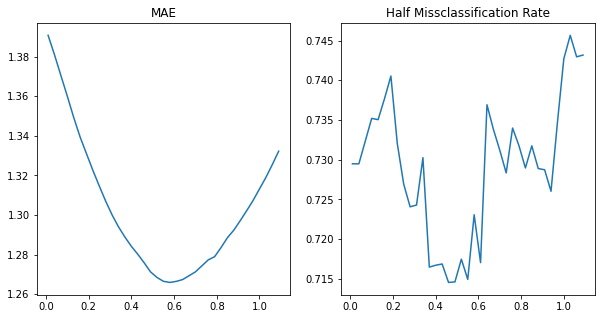

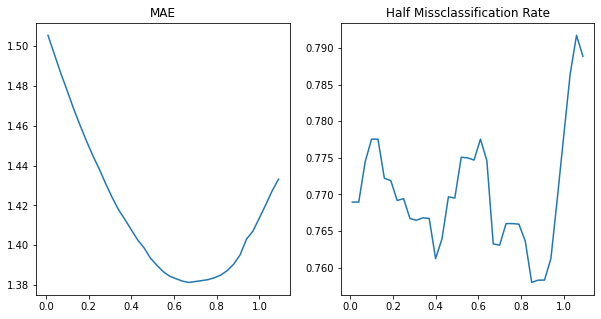

In [155]:
bias_weight_vals = np.arange(0.01, 1.1, 0.03)

evaluate_bias_weights(KNNWithAllUsersBias, X_train, y_diff_train, 
                      bias_weight_vals, 7, 2)
evaluate_bias_weights(KNNWithAllUsersBias, X_train, y_wl_train, 
                      bias_weight_vals, 7, 2)

In [156]:
print("KNN with all user bias:")
print("-----")
algo_biased_diff = KNNWithAllUsersBias(7,2,0.6)
print("-difficulty:")
evaluator.test_score(algo_biased_diff, X_train, y_diff_train, X_test, y_diff_test)
algo_biased_wl = KNNWithAllUsersBias(7,2,0.6)
print("-workload:")
evaluator.test_score(algo_biased_wl, X_train, y_wl_train, X_test, y_wl_test)

KNN with all user bias:
-----
-difficulty:
mae : 1.3447216729621108
rmse : 1.7415350025620007
half_miss_rate : 0.7553191489361702
was imposibole : 10  (out of 104 )
-workload:
mae : 1.2537858354748528
rmse : 1.5658189544493424
half_miss_rate : 0.776595744680851
was imposibole : 10  (out of 104 )


Again, we didn't get a major improvment.


explanation : we dont wanna bias an average user because we wreck the hmr

why does the misscalssification rate not improving?
maybe the neighbor is the biased one
maybe biasing by total users will work because only users biased from the avg ratings will be changed , more general

In [157]:
class KNNWithAllUsersThresoledBias(KNNUser): 
    def __init__(self, k=7,  min_support=2, bias_weight=1, bias_threshold = 1):
        super().__init__(k, min_support)
        self.bias_weight = bias_weight
        self.bias_threshold = bias_threshold
        self.users_means = dict()
        self.mean_mean_rating = None
    
    def train(self, X, y):
        super().train(X, y)
        # since we are computing all users means anyway, we are going to save
        # them in a dictionary. in production we are going to get the values
        # from the database and update it incrementaly every time user rates
        users = np.unique(X[:,0])
        for user in users:
            self.users_means[user] = y[ X[:,0] == user ].mean()

        self.mean_mean_rating = sum(self.users_means.values()) / len(self.users_means)

        biases = self.mean_mean_rating - np.array([self.users_means[X[i,0]] 
                                                   for i in range(len(y))])
        biases[np.absolute(biases)<self.bias_threshold] = 0

        self.y_old = np.copy(y)
        self.y = y + biases*self.bias_weight
        self.y[self.y>10] = 10
        self.y[self.y<1] = 1

    def predict(self, x):
        KNNGeneric.predict(self, x)
        user, course = x[0], x[1]

        neighbors_vec = self._get_knn_for_course(user, course)
        if neighbors_vec is None:
            return None
        
        neighbors_users = neighbors_vec[0, :]
        similarities = neighbors_vec[1, :]
        y_course = neighbors_vec[2, :]
                
        knn_prediction = y_course.mean()
        bias = self.users_means[user] - self.mean_mean_rating
        bias = 0 if np.absolute(bias)<self.bias_threshold else bias

        res = knn_prediction + bias * self.bias_weight
        # threshold:
        if res > 10 :
            res = 10
        elif res < 1:
            res = 1
            
        return res

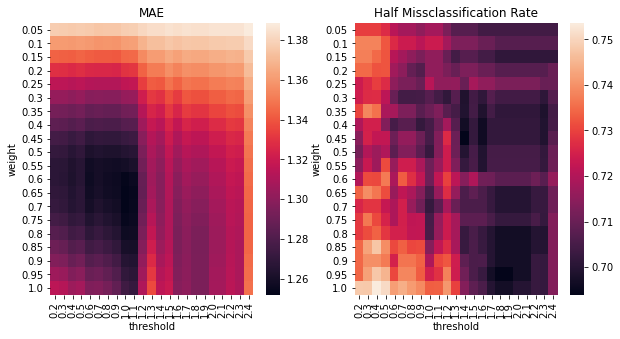

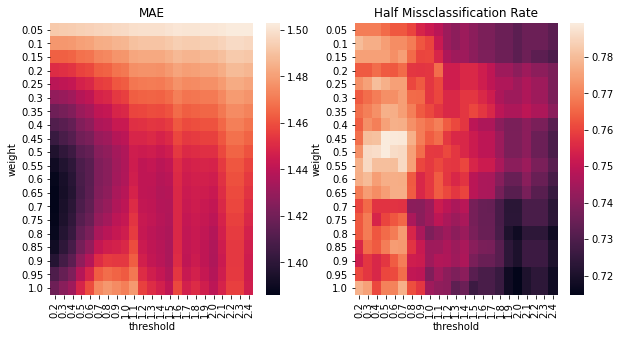

In [158]:
import seaborn as sns
 
def evaluate_bias_weights_and_thersholds(AlgoType, X, y, bias_weight_vals,
                                         bias_threshold_vals, k, min_support):
    """
     10-fold cross validates biased knn algorithms with constant k and 
     min support and sets of bias weight values and thresholds.
    plots the results.
    """
    evaluator = AlgorithmEvaluator(10, [mae, half_miss_rate], 2021)
    res_mae = np.zeros([len(bias_weight_vals), len( bias_threshold_vals)])
    res_hmr = np.zeros([len(bias_weight_vals), len( bias_threshold_vals)])
 
    for i, weight in enumerate(bias_weight_vals):
        for j, thr in enumerate(bias_threshold_vals):
            algo = AlgoType(bias_weight=weight, bias_threshold=thr)
            res_df = evaluator.evaluate(algo, X, y)
            res_mae[i,j] = res_df.iloc[10]["mae"]
            res_hmr[i,j] = res_df.iloc[10]["half_miss_rate"]
 
    fig,  axes = plt.subplots(1, 2)
    axes[0].set_title("MAE")
    axes[0] = sns.heatmap(res_mae,
                          xticklabels=np.around(bias_threshold_vals, 2),
                          yticklabels=np.around(bias_weight_vals, 2),
                          ax=axes[0])
    axes[0].set_xlabel("threshold")
    axes[0].set_ylabel("weight")
 
    axes[1].set_title("Half Missclassification Rate")
    axes[1] = sns.heatmap(res_hmr,
                          xticklabels=np.around(bias_threshold_vals, 2),
                          yticklabels=np.around(bias_weight_vals, 2),
                          ax=axes[1])
 
    axes[1].set_xlabel("threshold")
    axes[1].set_ylabel("weight")
 
 
bias_threshold_vals = np.arange(0.2, 2.5, 0.1)
bias_weight_vals = np.arange(0.05, 1.05, 0.05)

evaluate_bias_weights_and_thersholds(KNNWithAllUsersThresoledBias, X_train, y_diff_train, 
                      bias_weight_vals, bias_threshold_vals, 7, 2)

evaluate_bias_weights_and_thersholds(KNNWithAllUsersThresoledBias, X_train, y_wl_train, 
                      bias_weight_vals, bias_threshold_vals, 7, 2)

both metrics have distinct best values, we have a trade off and hmr is more important 


In [159]:
print("KNN with user bias threshold:")
print("-----")
algo_biased_threshold_diff = KNNWithAllUsersThresoledBias(k=7, 
                                                          min_support=2,
                                                          bias_weight=0.9, 
                                                          bias_threshold=1.9)
print("-difficulty:")
evaluator.test_score(algo_biased_threshold_diff, X_train, y_diff_train, X_test, y_diff_test)

algo_biased_threshold_wl = KNNWithAllUsersThresoledBias(k=7, 
                                                        min_support=2, 
                                                        bias_weight=0.9, 
                                                        bias_threshold=1.9)
print("-workload:")
evaluator.test_score(algo_biased_threshold_wl, X_train, y_wl_train, X_test, y_wl_test)

KNN with user bias threshold:
-----
-difficulty:
mae : 1.4682563628463108
rmse : 1.8752264941672183
half_miss_rate : 0.7127659574468085
was imposibole : 10  (out of 104 )
-workload:
mae : 1.3487481987754366
rmse : 1.6881534139092942
half_miss_rate : 0.723404255319149
was imposibole : 10  (out of 104 )


## Adding Weights
now let's combine our biased KNN with the weighted KNN

In [160]:
class WeightedKNNWithAllUsersThresoledBias(KNNUser): 
    def __init__(self, k=7,  min_support=2, bias_weight=1, bias_threshold = 1):
        super().__init__(k, min_support)
        self.bias_weight = bias_weight
        self.bias_threshold = bias_threshold
        self.users_means = dict()
        self.mean_mean_rating = None
    
    def train(self, X, y):
        super().train(X, y)
        # since we are computing all users means anyway, we are going to save
        # them in a dictionary. in production we are going to get the values
        # from the database and update it incrementaly every time user rates
        users = np.unique(X[:,0])
        for user in users:
            self.users_means[user] = y[ X[:,0] == user ].mean()

        self.mean_mean_rating = sum(self.users_means.values()) / len(self.users_means)

        biases = self.mean_mean_rating - np.array([self.users_means[X[i,0]] 
                                                   for i in range(len(y))])
        biases[np.absolute(biases)<self.bias_threshold] = 0

        self.y_old = np.copy(y)
        self.y = y + biases*self.bias_weight
        self.y[self.y>10] = 10
        self.y[self.y<1] = 1

    def predict(self, x):
        KNNGeneric.predict(self, x)
        user, course = x[0], x[1]

        neighbors_vec = self._get_knn_for_course(user, course)
        if neighbors_vec is None:
            return None
        
        neighbors_users = neighbors_vec[0, :]
        similarities = neighbors_vec[1, :]
        y_course = neighbors_vec[2, :]
                
        knn_prediction = np.inner(similarities, y_course) / np.sum(similarities)
        bias = self.users_means[user] - self.mean_mean_rating
        bias = 0 if np.absolute(bias)<self.bias_threshold else bias

        res = knn_prediction + bias * self.bias_weight
        
        # threshold:
        if res > 10 :
            res = 10
        elif res < 1:
            res = 1
            
        return res

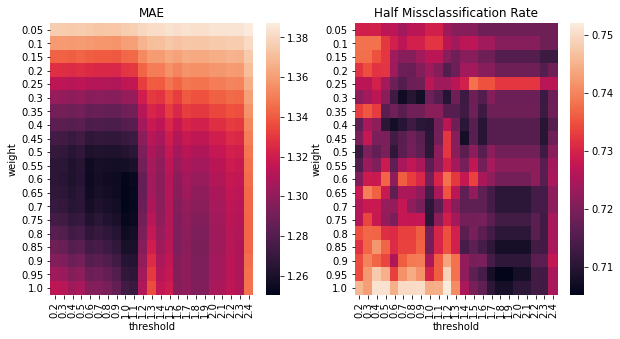

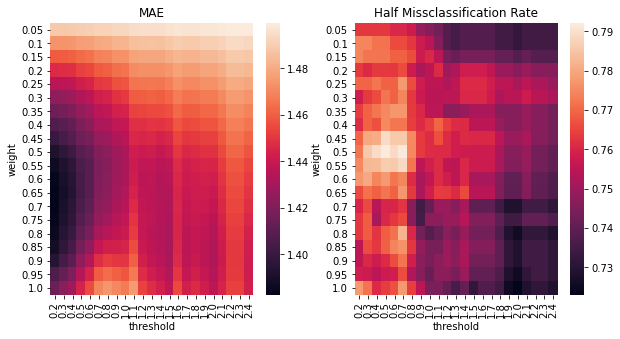

In [161]:
bias_threshold_vals = np.arange(0.2, 2.5, 0.1)
bias_weight_vals = np.arange(0.05, 1.05, 0.05)

evaluate_bias_weights_and_thersholds(WeightedKNNWithAllUsersThresoledBias, X_train, y_diff_train, 
                      bias_weight_vals, bias_threshold_vals, 7, 2)

evaluate_bias_weights_and_thersholds(WeightedKNNWithAllUsersThresoledBias, X_train, y_wl_train, 
                      bias_weight_vals, bias_threshold_vals, 7, 2)

In [162]:
print("Weighted KNN with user bias threshold:")
print("-----")
algo_weighted_biased_threshold_diff = WeightedKNNWithAllUsersThresoledBias(k=7, 
                                                          min_support=2,
                                                          bias_weight=0.9, 
                                                          bias_threshold=1.9)
print("-difficulty:")
evaluator.test_score(algo_weighted_biased_threshold_diff, X_train, y_diff_train, X_test, y_diff_test)

algo_weighted_biased_threshold_wl = WeightedKNNWithAllUsersThresoledBias(k=7, 
                                                        min_support=2, 
                                                        bias_weight=0.9, 
                                                        bias_threshold=1.9)
print("-workload:")
evaluator.test_score(algo_weighted_biased_threshold_wl, X_train, y_wl_train, X_test, y_wl_test)

Weighted KNN with user bias threshold:
-----
-difficulty:
mae : 1.4682132155085463
rmse : 1.8744251482445686
half_miss_rate : 0.7340425531914894
was imposibole : 10  (out of 104 )
-workload:
mae : 1.3495275594543101
rmse : 1.6900150077344547
half_miss_rate : 0.723404255319149
was imposibole : 10  (out of 104 )


Again, adding weights did not show any improvement

# Augmentation
cached data

In [163]:
class RecommenderWithAugmentation(GenericAlgorithm):
    def __init__(self, algorithm, augmentation_algo):
        super().__init__()
    
        self.algorithm = algorithm
        self.aug_alg = augmentation_algo

        self.X = None
        self.y = None
        self.X_aug = None
        self.y_aug = None

        self.users = None
    
    def train(self, X, y):
        super().train(X,y)
        self.X = X
        self.y = y
        
        self.aug_alg.train(X,y)
        self.users = np.unique(X[:,0])

        # keeping the augmentated data as list is easier to append to
        self.X_aug = []
        self.y_aug = [] 

    def predict(self, x):
        super().predict(x)

        (predicted_user, predicted_course) = x

        # find all the courses rated by the user and all the users rated the coruse:
        predicted_user_courses = self.X[ self.X[:,0] == predicted_user][:,1]
        predicted_course_raters = self.X[ self.X[:,1] == predicted_course][:,0]

        # create data, trying to create prediction for all the users rated the
        # predicted course for all the courses rated by predicted user
        for u in predicted_course_raters:
            for c in predicted_user_courses: 
                if not ([u, c] in self.X.tolist() or [u, c] in self.X_aug):
                    pred = self.aug_alg.predict([u,c])
                    if pred is not None:
                        self.X_aug.append([u, c]) 
                        self.y_aug.append(pred)
        
        X_all = np.concatenate((self.X, self.X_aug))
        y_all =  np.concatenate((self.y, self.y_aug))
        self.algorithm.train(X_all,y_all)
        return self.algorithm.predict(x)



In [164]:

algo_for_aug = KNNWithAllUsersThresoledBias(k=7, min_support=2,
                                            bias_weight=0.9, bias_threshold=1.9)
algo = KNNWithAllUsersThresoledBias(k=7, min_support=2,
                                    bias_weight=0.9, bias_threshold=1.9)

algo_with_aug = RecommenderWithAugmentation(algo, algo_for_aug)

print("KNN with user bias threshold and augmentation:")
print("-----")
print("-difficulty:")
evaluator.test_score(algo_with_aug, X_train, y_diff_train, X_test, y_diff_test)

print("-workload:")
evaluator.test_score(algo_with_aug, X_train, y_wl_train, X_test, y_wl_test)

KNN with user bias threshold and augmentation:
-----
-difficulty:
mae : 1.4793556537228272
rmse : 1.9107608419197373
half_miss_rate : 0.7291666666666666
was imposibole : 8  (out of 104 )
-workload:
mae : 1.3389274235587811
rmse : 1.6905133900459108
half_miss_rate : 0.75
was imposibole : 8  (out of 104 )


## weight of augmentation

In [165]:
class RecommenderWithWeightedAugmentation(GenericAlgorithm):
    def __init__(self, algorithm, augmentation_algo):
        super().__init__()
    
        self.algorithm = algorithm
        self.aug_alg = augmentation_algo

        self.X = None
        self.y = None
        self.X_aug = None
        self.y_aug = None

        self.users = None
    
    def train(self, X, y):
        super().train(X,y)
        self.X = X
        self.y = y
        
        self.aug_alg.train(X,y)
        self.users = np.unique(X[:,0])

        # keeping the augmentated data as list is easier to append to
        self.X_aug = []
        self.y_aug = [] 

    def predict(self, x):
        super().predict(x)

        (predicted_user, predicted_course) = x

        # find all the courses rated by the user and all the users rated the coruse:
        predicted_user_courses = self.X[ self.X[:,0] == predicted_user][:,1]
        predicted_course_raters = self.X[ self.X[:,1] == predicted_course][:,0]

        # create data, trying to create prediction for all the users rated the
        # predicted course for all the courses rated by predicted user
        for u in predicted_course_raters:
            for c in predicted_user_courses: 
                if not ([u, c] in self.X.tolist() or [u, c] in self.X_aug):
                    pred = self.aug_alg.predict([u,c])
                    if pred is not None:
                        self.X_aug.append([u, c]) 
                        self.y_aug.append(pred)
        
        # get prediction with augmanted data:
        X_all = np.concatenate((self.X, self.X_aug))
        y_all =  np.concatenate((self.y, self.y_aug))
        self.algorithm.train(X_all,y_all)
        aug_pred = self.algorithm.predict(x)

        # get original prediction if possible:
        self.aug_alg.train(self.X,self.y)
        original_pred  = self.aug_alg.predict(x)

        if original_pred is None and aug_pred is None:
            return None
        elif original_pred is None:
            return aug_pred
        else:
            return (aug_pred + original_pred)/2

In [166]:
algo_for_aug = KNNWithAllUsersThresoledBias(k=4, min_support=1,
                                            bias_weight=0.9, bias_threshold=0)
algo = KNNWithAllUsersThresoledBias(k=7, min_support=3,
                                    bias_weight=0.9, bias_threshold=0)

algo_with_aug = RecommenderWithWeightedAugmentation(algo, algo_for_aug)

print("KNN with user bias threshold and augmentation:")
print("-----")
print("-difficulty:")
evaluator.test_score(algo_with_aug, X_train, y_diff_train, X_test, y_diff_test)

print("-workload:")
evaluator.test_score(algo_with_aug, X_train, y_wl_train, X_test, y_wl_test)

KNN with user bias threshold and augmentation:
-----
-difficulty:
mae : 1.3744568566389128
rmse : 1.7677083449716922
half_miss_rate : 0.7395833333333334
was imposibole : 8  (out of 104 )
-workload:
mae : 1.2305888914956247
rmse : 1.5664534431492214
half_miss_rate : 0.7083333333333334
was imposibole : 8  (out of 104 )


#TODO

* find best parameters 
use mae + hmr + ??imposible/20??

* check minimum number of user ratings to predict